<a href="https://colab.research.google.com/github/yrodriguezmd/ace-it/blob/nov25/notebooks/01_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Generate a work flow for preprocessing and modelling image data for 3 classes of skin disorders

(Acne n= 40, Herpes simplex n= 16, Lichen planus n= 56)

*small dataset, mildly imbalanced*

Installations and Imports

In [ ]:
!pip install -q --upgrade fastai

In [2]:
import fastai
from fastai.vision.all import *

Access data

In [ ]:
!git clone https://github.com/yrodriguezmd/ace-it.git

In [ ]:
!ls ace-it 

data_3class_skin_diseases.zip  Readme.md  Tech-Challenge.pdf  test


In [4]:
%cd ace-it

/content/ace-it


In [ ]:
!ls

data_3class_skin_diseases.zip  Readme.md  Tech-Challenge.pdf  test


In [ ]:
!unzip \*zip && rm*.zip

In [ ]:
!ls data_3class_skin_diseases

acne  herpes_simplex  lichen_planus


In [6]:
path = Path('/content/ace-it/data_3class_skin_diseases')

In [ ]:
path.ls()

(#3) [Path('/content/ace-it/data_3class_skin_diseases/acne'),Path('/content/ace-it/data_3class_skin_diseases/herpes_simplex'),Path('/content/ace-it/data_3class_skin_diseases/lichen_planus')]

In [ ]:
!ls data_3class_skin_diseases/acne

4-100.jpg     4-102-4.jpg  4-103.jpg	 4-105-4.jpg  4-107.jpg    4-116-1.jpg
4-101-2.jpg   4-102-5.jpg  4-104_S.jpg	 4-105-5.jpg  4-108.jpg    4-116-2.jpg
4-101_S.jpg   4-102-6.jpg  4-105-10.jpg  4-105-6.jpg  4-110.jpg    4-98-1.jpg
4-102-11.jpg  4-102-7.jpg  4-105-11.jpg  4-105-7.jpg  4-111.jpg    4-98.jpg
4-102-12.jpg  4-102-8.jpg  4-105-1.jpg	 4-105-9.jpg  4-114.jpg    4-99.jpg
4-102-1.jpg   4-102-9.jpg  4-105-2.jpg	 4-105.jpg    4-115-1.jpg
4-102-3.jpg   4-102.jpg    4-105-3.jpg	 4-106.jpg    4-115.jpg


Sample tensor and visual check

In [ ]:
from PIL import Image, ImageOps
samp = Image.open('/content/ace-it/data_3class_skin_diseases/acne/4-100.jpg')##
#show_image(samp);

In [ ]:
samp_t = tensor(samp)
samp_t.shape

torch.Size([298, 420, 3])

Verify images: remove items that cannot be opened

In [7]:
path = Path('/content/ace-it/data_3class_skin_diseases/')
sets = ['acne','herpes_simplex','lichen_planus']
for s in sets:
  sub_path = path/s
  no_open = verify_images(sub_path.ls())
  print(no_open)
  no_open.map(Path.unlink)  # remove image that can't be opened 


[]
[]
[Path('/content/ace-it/data_3class_skin_diseases/lichen_planus/3-124-2.jpg')]


In [ ]:
!ls data_3class_skin_diseases/lichen_planus
# 3-124-2.jpg removed

Create DataBlock and DataLoader

In [8]:
path = Path('/content/ace-it/data_3class_skin_diseases')

dblock = DataBlock(
    blocks = (ImageBlock(), CategoryBlock()),
    get_items = get_image_files,
    splitter = RandomSplitter(seed=42, valid_pct=0.2),
    get_y= parent_label,
    item_tfms = Resize(460),#
    batch_tfms = [(*aug_transforms (size=200, max_rotate=20, max_zoom=1.2)),
                  Normalize.from_stats(*imagenet_stats)],
)

dls = dblock.dataloaders(path, bs = 64)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


Visual check

In [ ]:
dls.train.show_batch()

In [ ]:
dblock.summary(path)

Simple CNN architecture

In [9]:
# input 200x200x3
cnn = sequential(
    (nn.Conv2d(in_channels = 3, out_channels = 8, # 
              kernel_size = 5,
              stride=2,
               padding = 5//2)),# 100
    (nn.ReLU()),
    (nn.BatchNorm2d(8)), 

    (nn.Conv2d(in_channels = 8, out_channels = 16,
          kernel_size = 5,
          stride=2,
          padding =5//2)), # 50
    (nn.ReLU()), 
    (nn.BatchNorm2d(16)), 
    
    (nn.Conv2d(in_channels = 16, out_channels = 32,
          kernel_size = 5,
          stride=2,
          padding=5//2)), # 25
    (nn.ReLU()),
    (nn.BatchNorm2d(32)), 

    (nn.Conv2d(in_channels = 32, out_channels = 64,
          kernel_size = 5,
          stride=2,
          padding=5//2)), # 13
    (nn.ReLU()),
    (nn.BatchNorm2d(64)), 

    (nn.Conv2d(in_channels = 64, out_channels = 128,
          kernel_size = 5,
          stride=2,
          padding=5//2)), # 7
    (nn.ReLU()),
    (nn.BatchNorm2d(128)), 

    (nn.Conv2d(in_channels = 128, out_channels = 256,
          kernel_size = 3,
          stride=2,
          padding=3//2)), # 4
    (nn.ReLU()),
    (nn.BatchNorm2d(256)), 

    (nn.Conv2d(in_channels = 256, out_channels = 512,
          kernel_size = 3,
          stride=2,
          padding=3//2)), # 2
    (nn.ReLU()),
    (nn.BatchNorm2d(512)), 

    (nn.Conv2d(in_channels = 512, out_channels = 3,##
          kernel_size = 3,
          stride=2,
          padding =3//2)), # 1
          
    (Flatten())
)

Software for logging and callbacks (optional)

In [ ]:
!pip install -qqq wandb

import wandb
from fastai.callback.wandb import *
from fastai.callback.tracker import SaveModelCallback

In [ ]:
wandb.login()

In [ ]:
wandb.init(project = 'Derm',name='simplecnn_nov25')

Modelling

In [14]:
learn = Learner(dls, cnn, 
                #loss_func = F.cross_entropy,
                metrics = accuracy,
                cbs = [WandbCallback(), SaveModelCallback()])

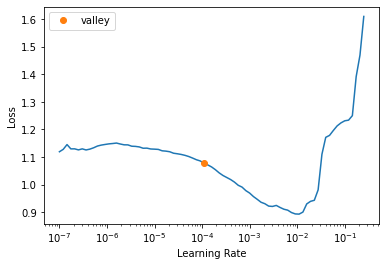

In [15]:
lr_valley = learn.lr_find()

In [16]:
learn.fit_one_cycle(n_epoch = 100, lr_max= lr_valley[0]) 

epoch,train_loss,valid_loss,accuracy,time
0,1.190047,1.097928,0.545455,00:02
1,1.164309,1.095065,0.590909,00:03
2,1.148429,1.092039,0.590909,00:03
3,1.138618,1.089298,0.590909,00:03
4,1.136324,1.086805,0.590909,00:03
5,1.121017,1.084348,0.590909,00:03
6,1.126902,1.082809,0.590909,00:03
7,1.129295,1.081748,0.590909,00:03
8,1.125360,1.081392,0.590909,00:03
9,1.116919,1.081572,0.590909,00:03


Better model found at epoch 0 with valid_loss value: 1.0979282855987549.
Better model found at epoch 1 with valid_loss value: 1.095064640045166.
Better model found at epoch 2 with valid_loss value: 1.0920385122299194.
Better model found at epoch 3 with valid_loss value: 1.0892983675003052.
Better model found at epoch 4 with valid_loss value: 1.0868051052093506.
Better model found at epoch 5 with valid_loss value: 1.0843478441238403.
Better model found at epoch 6 with valid_loss value: 1.0828089714050293.
Better model found at epoch 7 with valid_loss value: 1.0817484855651855.
Better model found at epoch 8 with valid_loss value: 1.08139169216156.
Better model found at epoch 17 with valid_loss value: 1.079950213432312.
Better model found at epoch 18 with valid_loss value: 1.073979139328003.
Better model found at epoch 19 with valid_loss value: 1.0646506547927856.
Better model found at epoch 20 with valid_loss value: 1.0536305904388428.
Better model found at epoch 21 with valid_loss value

In [ ]:
#preds, targs = learn.tta()
#accuracy(preds, targs).item()

0.5909090638160706

In [ ]:
#print(len(targs))
#print(targs)

22
TensorCategory([0, 0, 1, 0, 2, 2, 1, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 2, 1])


Checking predictions for the validation set

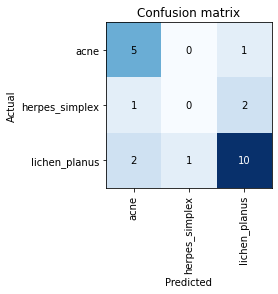

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Option to do Inference prior to saving the Model

In [ ]:
!ls test

acne  herpes_simplex  lichen_planus  README.md


In [18]:
test_path = Path('test')

In [ ]:
test_path.ls()

(#4) [Path('test/lichen_planus'),Path('test/herpes_simplex'),Path('test/acne'),Path('test/README.md')]

In [19]:
test_images = get_image_files(test_path)
#image_array = [PIL.Image.open(file) for file in test_images]
#image_array = [image.convert('RGB') for image in image_array]

In [ ]:
test_images

(#9) [Path('test/lichen_planus/test3_lich.jpeg'),Path('test/lichen_planus/test1_lich.jpeg'),Path('test/lichen_planus/test2_lich.jpeg'),Path('test/herpes_simplex/test2_herp.jpeg'),Path('test/herpes_simplex/test3_herp.jpeg'),Path('test/herpes_simplex/test1_herp.jpeg'),Path('test/acne/test2_acne.jpeg'),Path('test/acne/test1_acne.jpeg'),Path('test/acne/test3_acne.jpeg')]

In [20]:
ground_list = []
for i in range(len(test_images)):
  ground = test_images[i]
  ground_list.append(str(ground))

In [21]:
predicted_list = []
for i in range(len(test_images)):
  predicted = learn.predict(test_images[i])[0]
  predicted_list.append(str(predicted))

In [22]:
for i in range(len(predicted_list)):
  predicted_list[i] = predicted_list[i][:4]

In [23]:
for i in range(len(ground_list)):
  ground_list[i] = ground_list[i][-9:-5]

In [24]:
list(zip(ground_list, predicted_list))

[('lich', 'acne'),
 ('lich', 'lich'),
 ('lich', 'acne'),
 ('herp', 'herp'),
 ('herp', 'lich'),
 ('herp', 'acne'),
 ('acne', 'herp'),
 ('acne', 'acne'),
 ('acne', 'lich')]

In [25]:
correct = 0
for i in range(len(ground_list)):
  if ground_list[i] == predicted_list[i]:
    correct +=1

In [26]:
percent_correct = correct / len(ground_list)
print('Percent of correct predictions on test set:', round(percent_correct *100), '%')

Percent of correct predictions on test set: 33 %


Save the Model

In [27]:
# create 'export.pkl' file in ace-it folder
learn.export()

In [28]:
path = Path()
path.ls(file_exts= '.pkl')

(#1) [Path('export.pkl')]

(Loading the Model shown in Inference Notebook)